In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import OrderedDict
sns.set()

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler, QuantileTransformer
# Algorithms
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA

from tools import *

DATA_DIR = Path('../../data')
PROC_DIR = Path(DATA_DIR / 'processed')
OUT_DIR = Path('./out/pca_joint')

if not OUT_DIR.exists():
    Path.mkdir(OUT_DIR)
    

flow_columns = ['R [Rsun]', 'B [G]', 'alpha [deg]']
MAX_CLUSTERS = 8

# Load data

In [3]:
filenames = [f for f in PROC_DIR.iterdir()]

flows_dict = OrderedDict()
for f in filenames:
    flows_dict[f.stem] = pd.read_csv(f, usecols=['R [Rsun]', 'B [G]', 'alpha [deg]'])
        
    

## Scale Inputs

In [69]:

# # concat flows
# scaled_flows = list(flows_dict.values())
# scaled_flows = pd.concat(scaled_flows, axis=0)

# scaler = MinMaxScaler((-1,1))
# scaler.fit(scaled_flows)
# scaled_flows = scaler.transform(scaled_flows)

# scaled_flows = pd.DataFrame(scaled_flows, columns=flow_columns)
# print(scaled_flows.shape)
# print(scaled_flows.head())

In [4]:
# concat flows
scaled_flows = list(flows_dict.values())
scaled_flows = pd.concat(scaled_flows, axis=0)

scaler = QuantileTransformer()
scaler.fit(scaled_flows)
scaled_flows = scaler.transform(scaled_flows)

scaled_flows = pd.DataFrame(scaled_flows, columns=flow_columns)
print(scaled_flows.shape)
print(scaled_flows.head())

(7533440, 3)
   R [Rsun]     B [G]  alpha [deg]
0  0.000000  0.835356     0.241527
1  0.003003  0.835268     0.241751
2  0.004004  0.835180     0.241979
3  0.006006  0.835092     0.242211
4  0.008008  0.835004     0.242402


# All Columns

In [5]:
# separate into file series
scaled_all = [scaled_flows.iloc[i*640:i*640+640, :] for i in range(len(scaled_flows) // 640)]
scaled_all = [flow.values for flow in scaled_all]
scaled_all = np.array([flow.ravel() for flow in np.array(scaled_all)])
scaled_all.shape

(11771, 1920)

In [6]:
scaled_all[0][:20]

array([0.        , 0.83535596, 0.24152704, 0.003003  , 0.83526824,
       0.24175102, 0.00400432, 0.83518033, 0.2419791 , 0.00600603,
       0.83509224, 0.24221133, 0.00800802, 0.83500397, 0.24240246,
       0.0090091 , 0.83491552, 0.24259009, 0.01092739, 0.8348245 ])

## PCA

In [7]:
pca_640 = PCA(n_components=640)
pca_640.fit(scaled_all)
transf_pca_640 = pca_640.transform(scaled_all)

print("Variance by explained by all components: {:.2f}".format(sum(pca_640.explained_variance_ratio_)*100))

Variance by explained by all components: 100.00


[Text(0.5, 0, 'Number of Components'),
 Text(0, 0.5, 'Cumulative Explained Variance (%)'),
 (0.0, 6.0)]

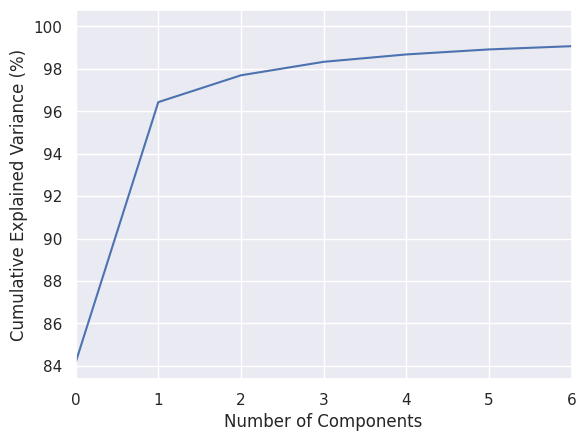

In [8]:
lp = sns.lineplot(np.cumsum(pca_640.explained_variance_ratio_*100))
lp.set(xlabel='Number of Components', ylabel='Cumulative Explained Variance (%)', xlim=(0, 6))

> **Dimensionality**: Most of the data (about 98%) is explained by only 2 components

In [9]:
pca = PCA(n_components=2)
transformed_all = pca.fit_transform(scaled_all)
transformed_all.shape

(11771, 2)

<AxesSubplot: >

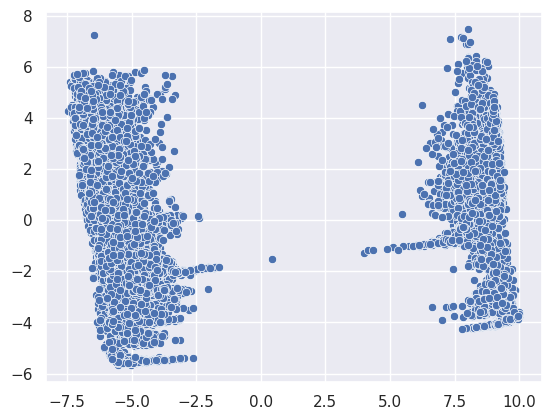

In [10]:
sns.scatterplot(x=transformed_all[:, 0], y=transformed_all[:, 1])

## K-Means

[Text(0.5, 0, 'Number of clusters'),
 Text(0, 0.5, 'Distortion'),
 Text(0.5, 1.0, 'Elbow Plot')]

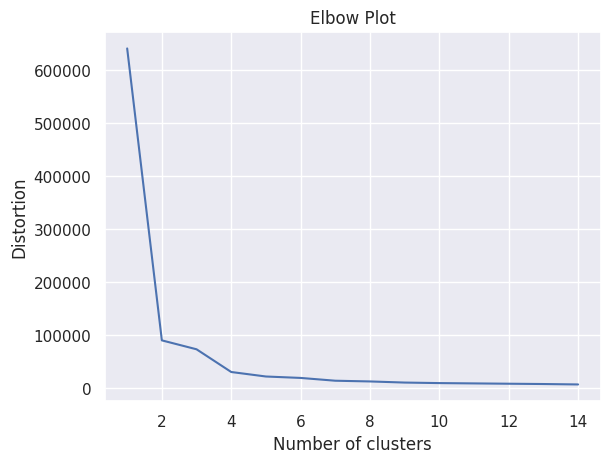

In [11]:
# Elbow Test
distortions = []
K = range(1, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, max_iter=5000, n_init='auto')
    kmeans.fit(transformed_all)
    distortions.append(kmeans.inertia_)
    
ep = sns.lineplot(x=K, y=distortions)
ep.set(xlabel='Number of clusters', ylabel='Distortion', title='Elbow Plot')

In [12]:
kmeans = KMeans(n_clusters=3,max_iter=500, n_init='auto')
pca_kmeans_labels = kmeans.fit_predict(scaled_all)
nclusters = len(set(pca_kmeans_labels))

<AxesSubplot: >

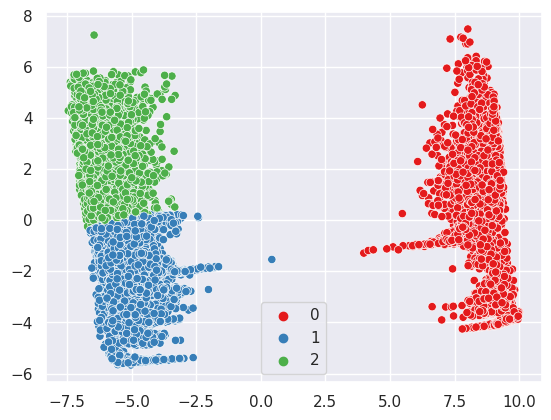

In [13]:
sns.scatterplot(x=transformed_all[:, 0], y=transformed_all[:, 1], hue=pca_kmeans_labels, palette='Set1')

### Original Data

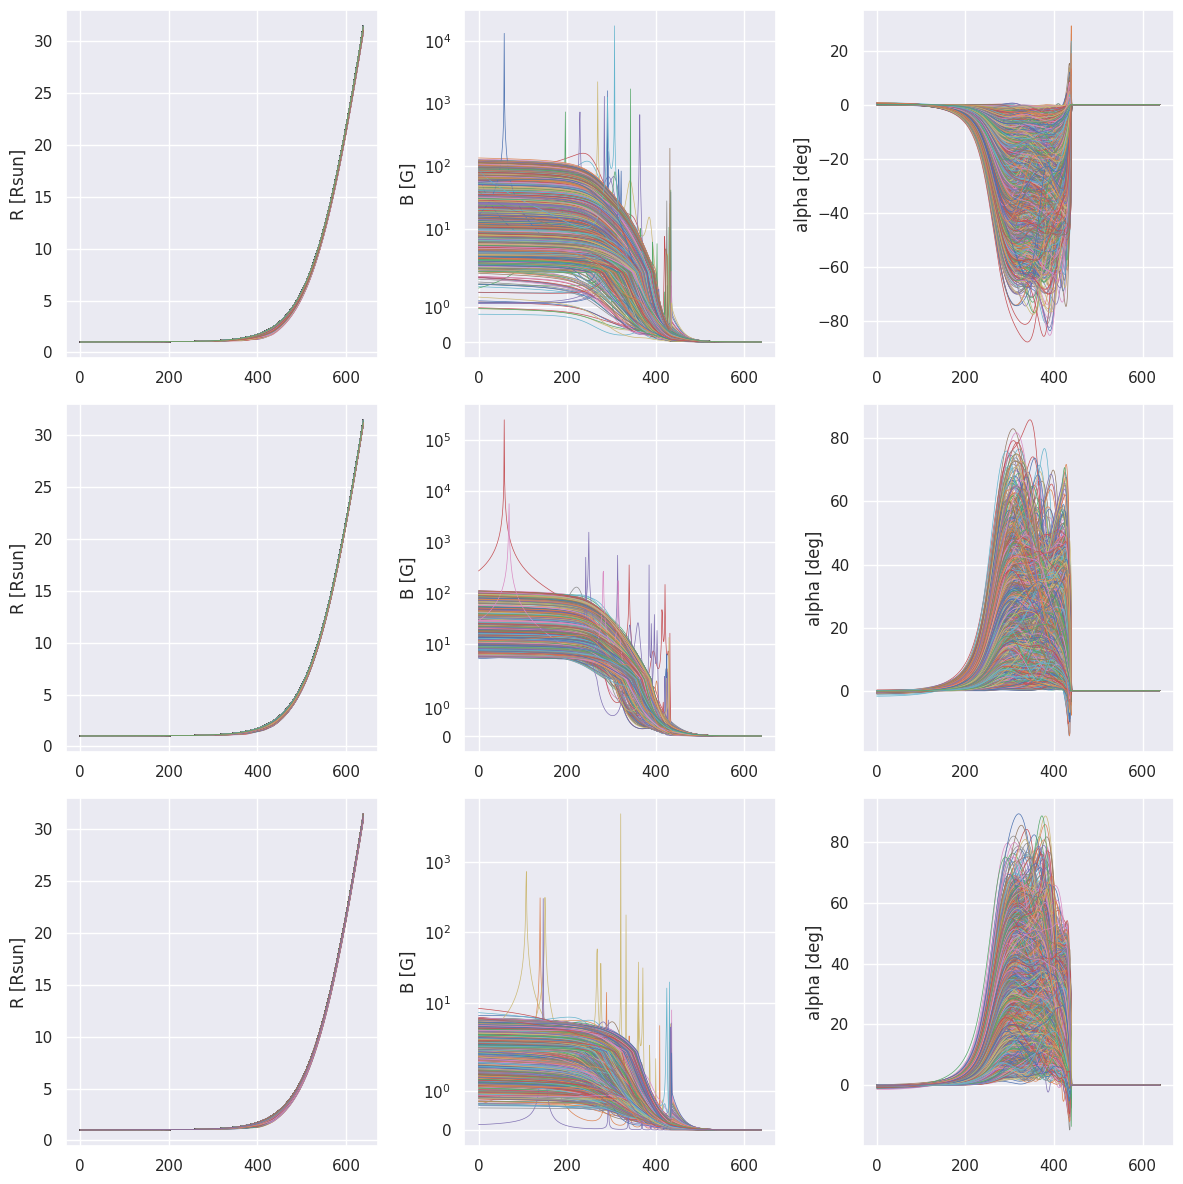

In [14]:
plot_unscaled_clusters(pca_kmeans_labels, nclusters, flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'Number of files')]

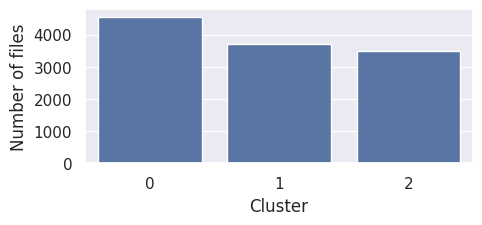

In [15]:
fig, ax = plt.subplots(figsize=(5, 2))
bp = sns.countplot(x=pca_kmeans_labels, ax=ax, color='b')
bp.set(xlabel='Cluster', ylabel='Number of files')

### Grid Search

In [16]:
# %%capture
# subdir = OUT_DIR / 'kmeans'
# if not subdir.exists():
#     subdir.mkdir(parents=True)
    
# for k in range(2, 5):
#     kmeans = KMeans(n_clusters=k, max_iter=5000, n_init='auto')
#     kmeans_labels = kmeans.fit_predict(transformed_all)
    
#     sns.scatterplot(x=transformed_all[:, 0], y=transformed_all[:, 1], hue=kmeans_labels, palette='Set1')
#     plt.savefig(subdir / f'scatter_{k}.png', dpi=200)
#     plot_unscaled_clusters(kmeans_labels, k, flows_dict, flow_columns, save_path=subdir / f'unscaled_{k}.png', yscale={'B [G]': 'log'})

## Hierarchical Clustering

In [17]:
agg = AgglomerativeClustering(compute_distances=True, n_clusters=3, compute_full_tree=True, linkage='average')
agg = agg.fit(transformed_all)
nclusters = len(set(agg.labels_))

Text(0.5, 0, 'Number of points in node')

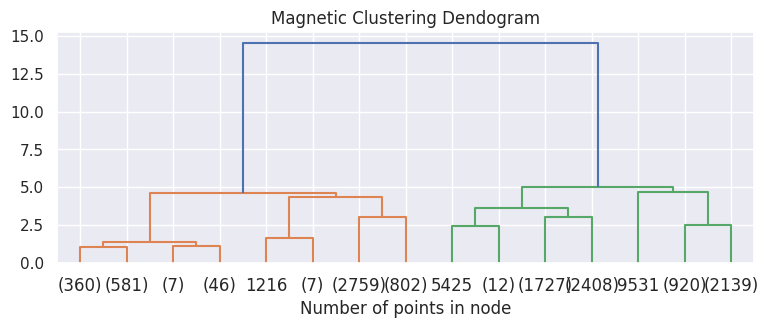

In [18]:
plt.figure(figsize=(9, 3))
plt.title("Magnetic Clustering Dendogram")
plot_dendrogram(agg, truncate_mode='level', p=3)
plt.xlabel("Number of points in node")

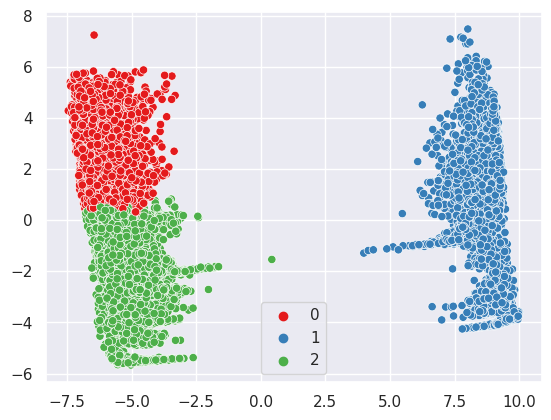

In [19]:
sp = sns.scatterplot(x=transformed_all[:, 0], y=transformed_all[:, 1], hue=agg.labels_, palette='Set1')
# sp.legend_.remove()


### Original Data

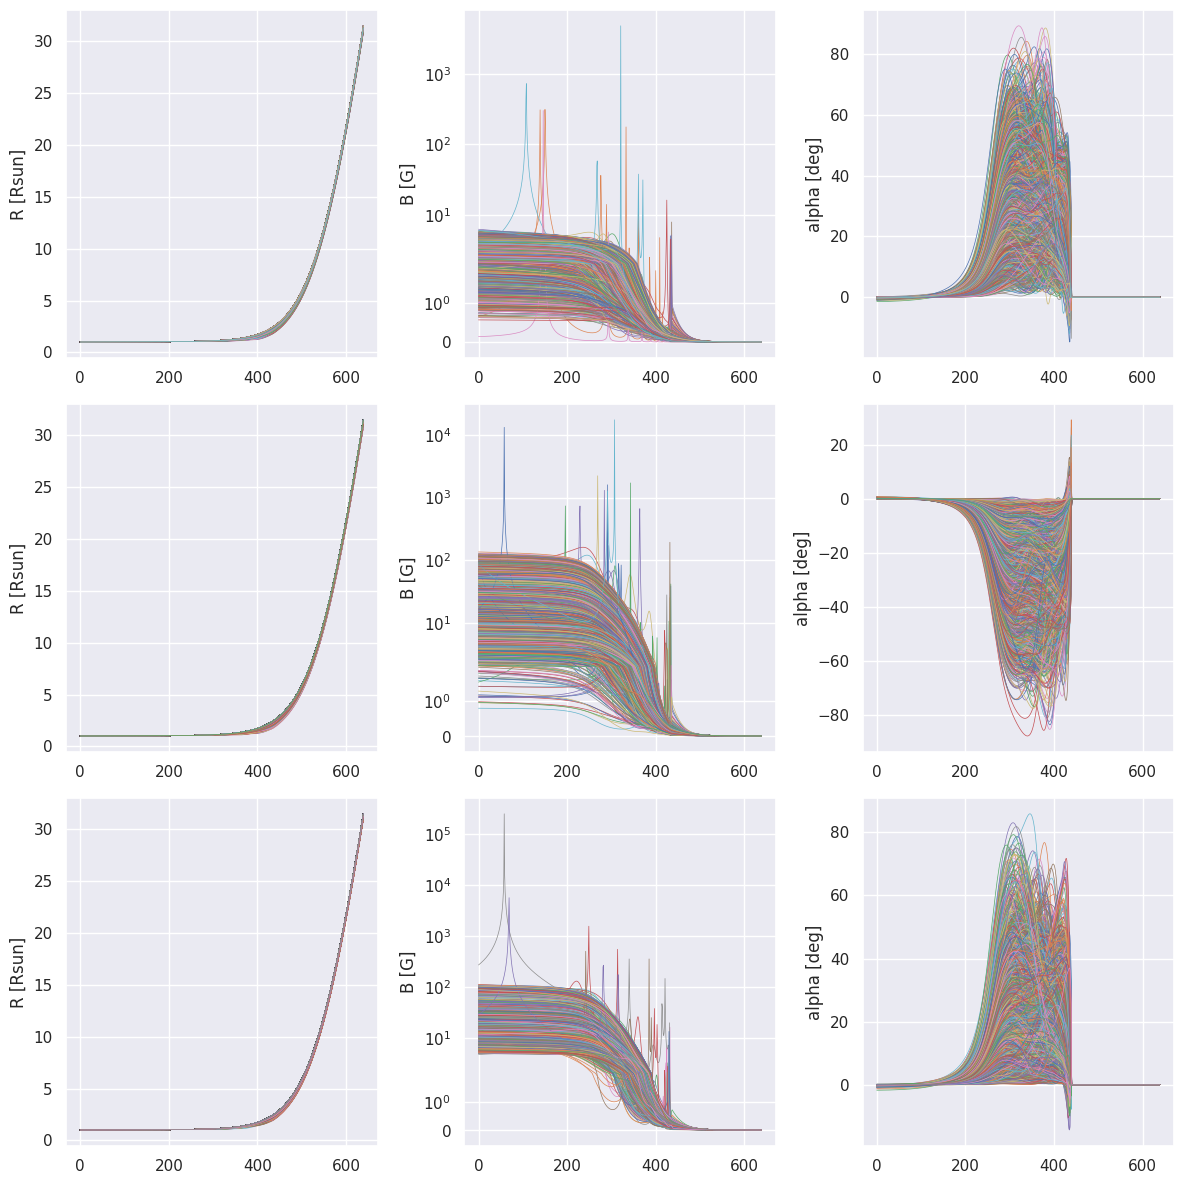

In [20]:
plot_unscaled_clusters(agg.labels_, nclusters, flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

<AxesSubplot: ylabel='count'>

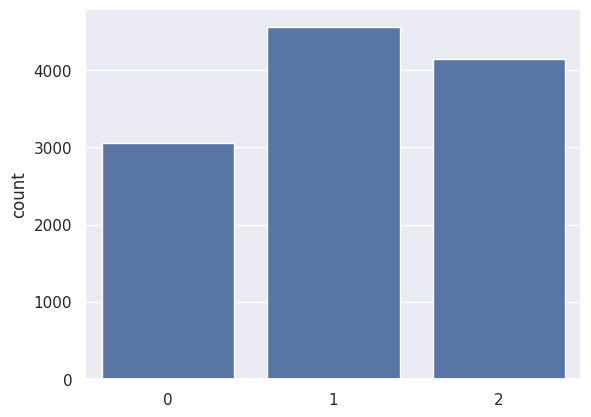

In [21]:
sns.countplot(x=agg.labels_, color='b')

### Grid Search

In [22]:
# %%capture
# sub_dir = OUT_DIR / 'hierarchical'
# if not sub_dir.exists():
#     sub_dir.mkdir()
    
# for i in range(2, MAX_CLUSTERS):
#     agg = AgglomerativeClustering(compute_distances=True, n_clusters=i, compute_full_tree=True, linkage='average')
#     agg = agg.fit(transformed_all)
    
#     sp = sns.scatterplot(x=transformed_all[:, 0], y=transformed_all[:, 1], hue=agg.labels_, palette='Set1') 
#     plt.savefig(sub_dir / f'scatter_{i}.png', dpi=200)
    
#     plot_unscaled_clusters(agg.labels_, i, flows_dict, flow_columns, save_path=sub_dir / f'unscaled_{i}.png', yscale={'B [G]': 'log'}) 
    

## DBSCAN

In [23]:
dbscan = DBSCAN(eps=0.5, min_samples=5, n_jobs=2)
dbscan_labels = dbscan.fit_predict(transformed_all)
nclusters = len(set(dbscan_labels))

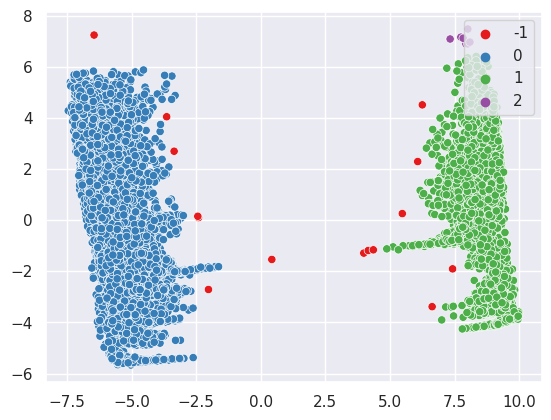

In [24]:
sp = sns.scatterplot(x=transformed_all[:, 0], y=transformed_all[:, 1], hue=dbscan_labels, palette='Set1')
plt.legend(loc='upper right')

### Original Data

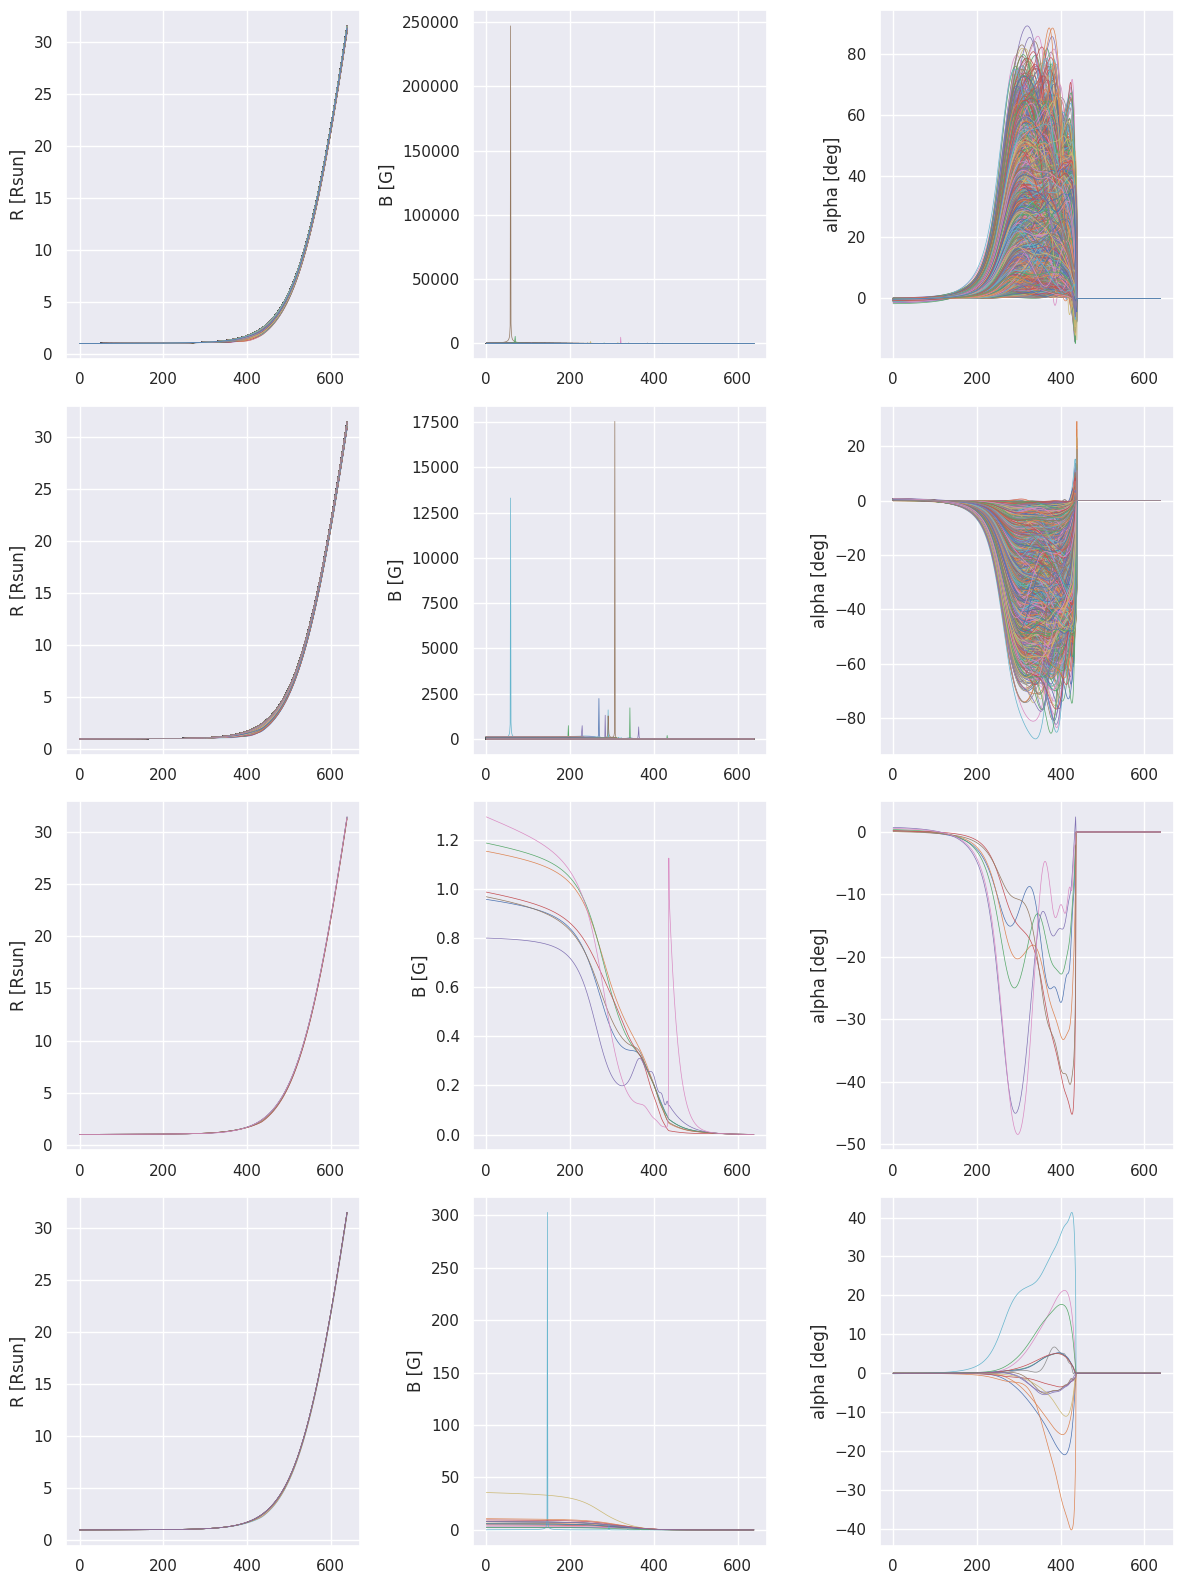

In [25]:
plot_unscaled_clusters(dbscan_labels, nclusters, flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

<AxesSubplot: ylabel='count'>

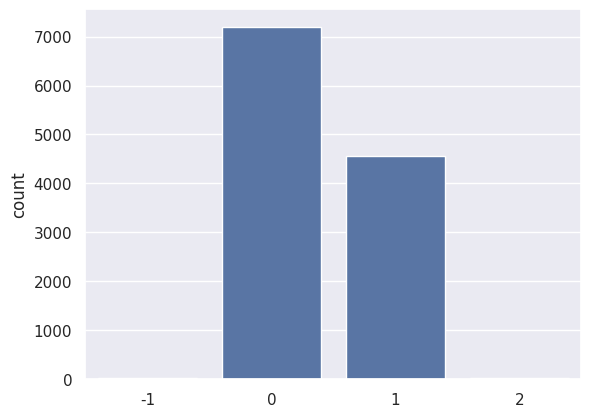

In [26]:
sns.countplot(x=dbscan_labels, color='b')

### Grid Search

In [27]:
# %%capture
# sub_dir = OUT_DIR / 'dbscan'
# if not sub_dir.exists():
#     sub_dir.mkdir()


# for k in range(3, 640):
#     for i in np.arange(0.05, 0.9, 0.05):
#         dbscan = DBSCAN(eps=i, min_samples=k, n_jobs=-1)
#         dbscan_labels = dbscan.fit_predict(transformed_all)
        
#         nclusters = len(set(dbscan_labels))
#         if (nclusters > MAX_CLUSTERS or nclusters < 2):
#             continue
        
#         save_i = int(i*100)
#         sp = sns.scatterplot(x=transformed_all[:, 0], y=transformed_all[:, 1], hue=dbscan_labels, palette='Set1')
#         plt.legend(loc='upper right')
#         plt.savefig(sub_dir / f'scatter_{k}_{save_i}.png', dpi=200)
        
#         plot_unscaled_clusters(dbscan_labels, len(set(dbscan_labels)), flows_dict, flow_columns, 
#                                save_path=sub_dir / f'unscaled_{k}_{save_i}.png', yscale={'B [G]': 'log'})
    

# Magnetic Field + Inclination

In [28]:
# separate into file series
scaled_mag_inc = [scaled_flows.iloc[i*640:i*640+640, 1:] for i in range(len(scaled_flows) // 640)]
scaled_mag_inc = [flow.values for flow in scaled_mag_inc]
scaled_mag_inc = np.array([flow.ravel() for flow in np.array(scaled_mag_inc)])
scaled_mag_inc.shape

(11771, 1280)

## PCA

In [29]:
pca_640 = PCA(n_components=640)
pca_640.fit(scaled_mag_inc)
transf_pca_640 = pca_640.transform(scaled_mag_inc)

print("Variance by explained by all components: {:.2f}".format(sum(pca_640.explained_variance_ratio_)*100))

Variance by explained by all components: 100.00


[Text(0.5, 0, 'Number of Components'),
 Text(0, 0.5, 'Cumulative Explained Variance (%)'),
 (0.0, 6.0)]

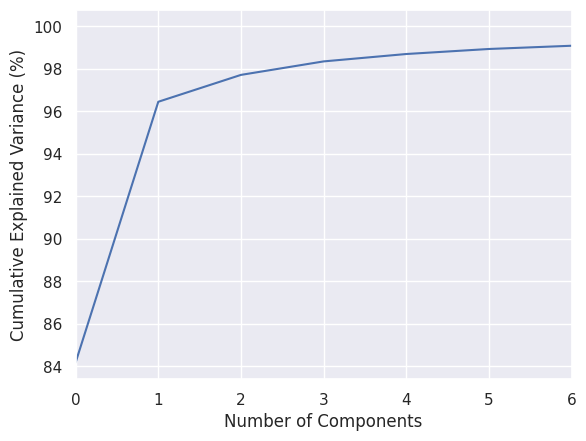

In [30]:
lp = sns.lineplot(np.cumsum(pca_640.explained_variance_ratio_*100))
lp.set(xlabel='Number of Components', ylabel='Cumulative Explained Variance (%)', xlim=(0, 6))

In [31]:
pca = PCA(n_components=2)
transformed_mag_inc = pca.fit_transform(scaled_mag_inc)
transformed_mag_inc

array([[-4.74589749, -1.1026881 ],
       [-4.86380307, -2.73457814],
       [ 8.2926705 ,  4.75311318],
       ...,
       [-6.30263408,  2.32708326],
       [ 8.72124685,  3.18759901],
       [ 7.83126775,  1.8848726 ]])

<AxesSubplot: >

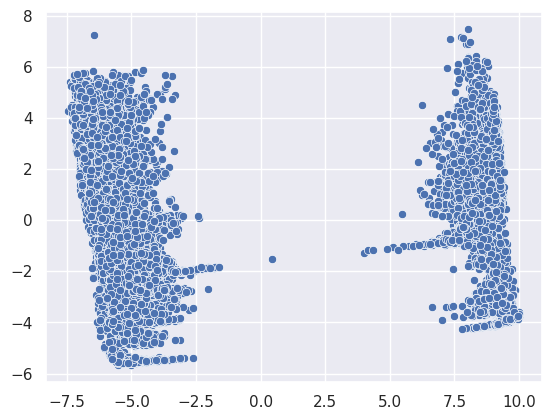

In [32]:
sns.scatterplot(x=transformed_mag_inc[:, 0], y=transformed_mag_inc[:, 1])

## K-Means

[Text(0.5, 0, 'Number of clusters'),
 Text(0, 0.5, 'Distortion'),
 Text(0.5, 1.0, 'Elbow Plot')]

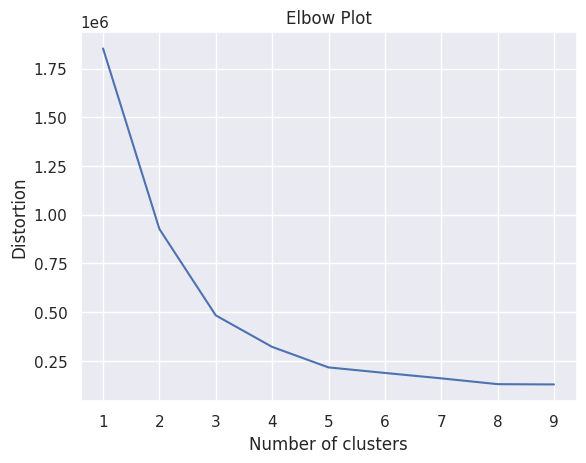

In [33]:
# Elbow Test
distortions = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, max_iter=5000, n_init='auto')
    kmeans.fit(scaled_flows)
    distortions.append(kmeans.inertia_)
    
ep = sns.lineplot(x=K, y=distortions)
ep.set(xlabel='Number of clusters', ylabel='Distortion', title='Elbow Plot')
    

In [34]:
kmeans = KMeans(n_clusters=8,max_iter=5000, n_init='auto')
pca_kmeans_mag_inc_labels = kmeans.fit_predict(transformed_mag_inc)
nclusters = len(set(pca_kmeans_mag_inc_labels))

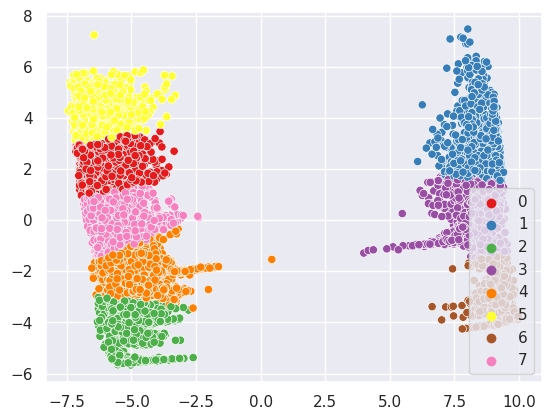

In [35]:
sp = sns.scatterplot(x=transformed_mag_inc[:, 0], y=transformed_mag_inc[:, 1], hue=pca_kmeans_mag_inc_labels, palette='Set1')
plt.legend(loc='lower right')

### Original Data

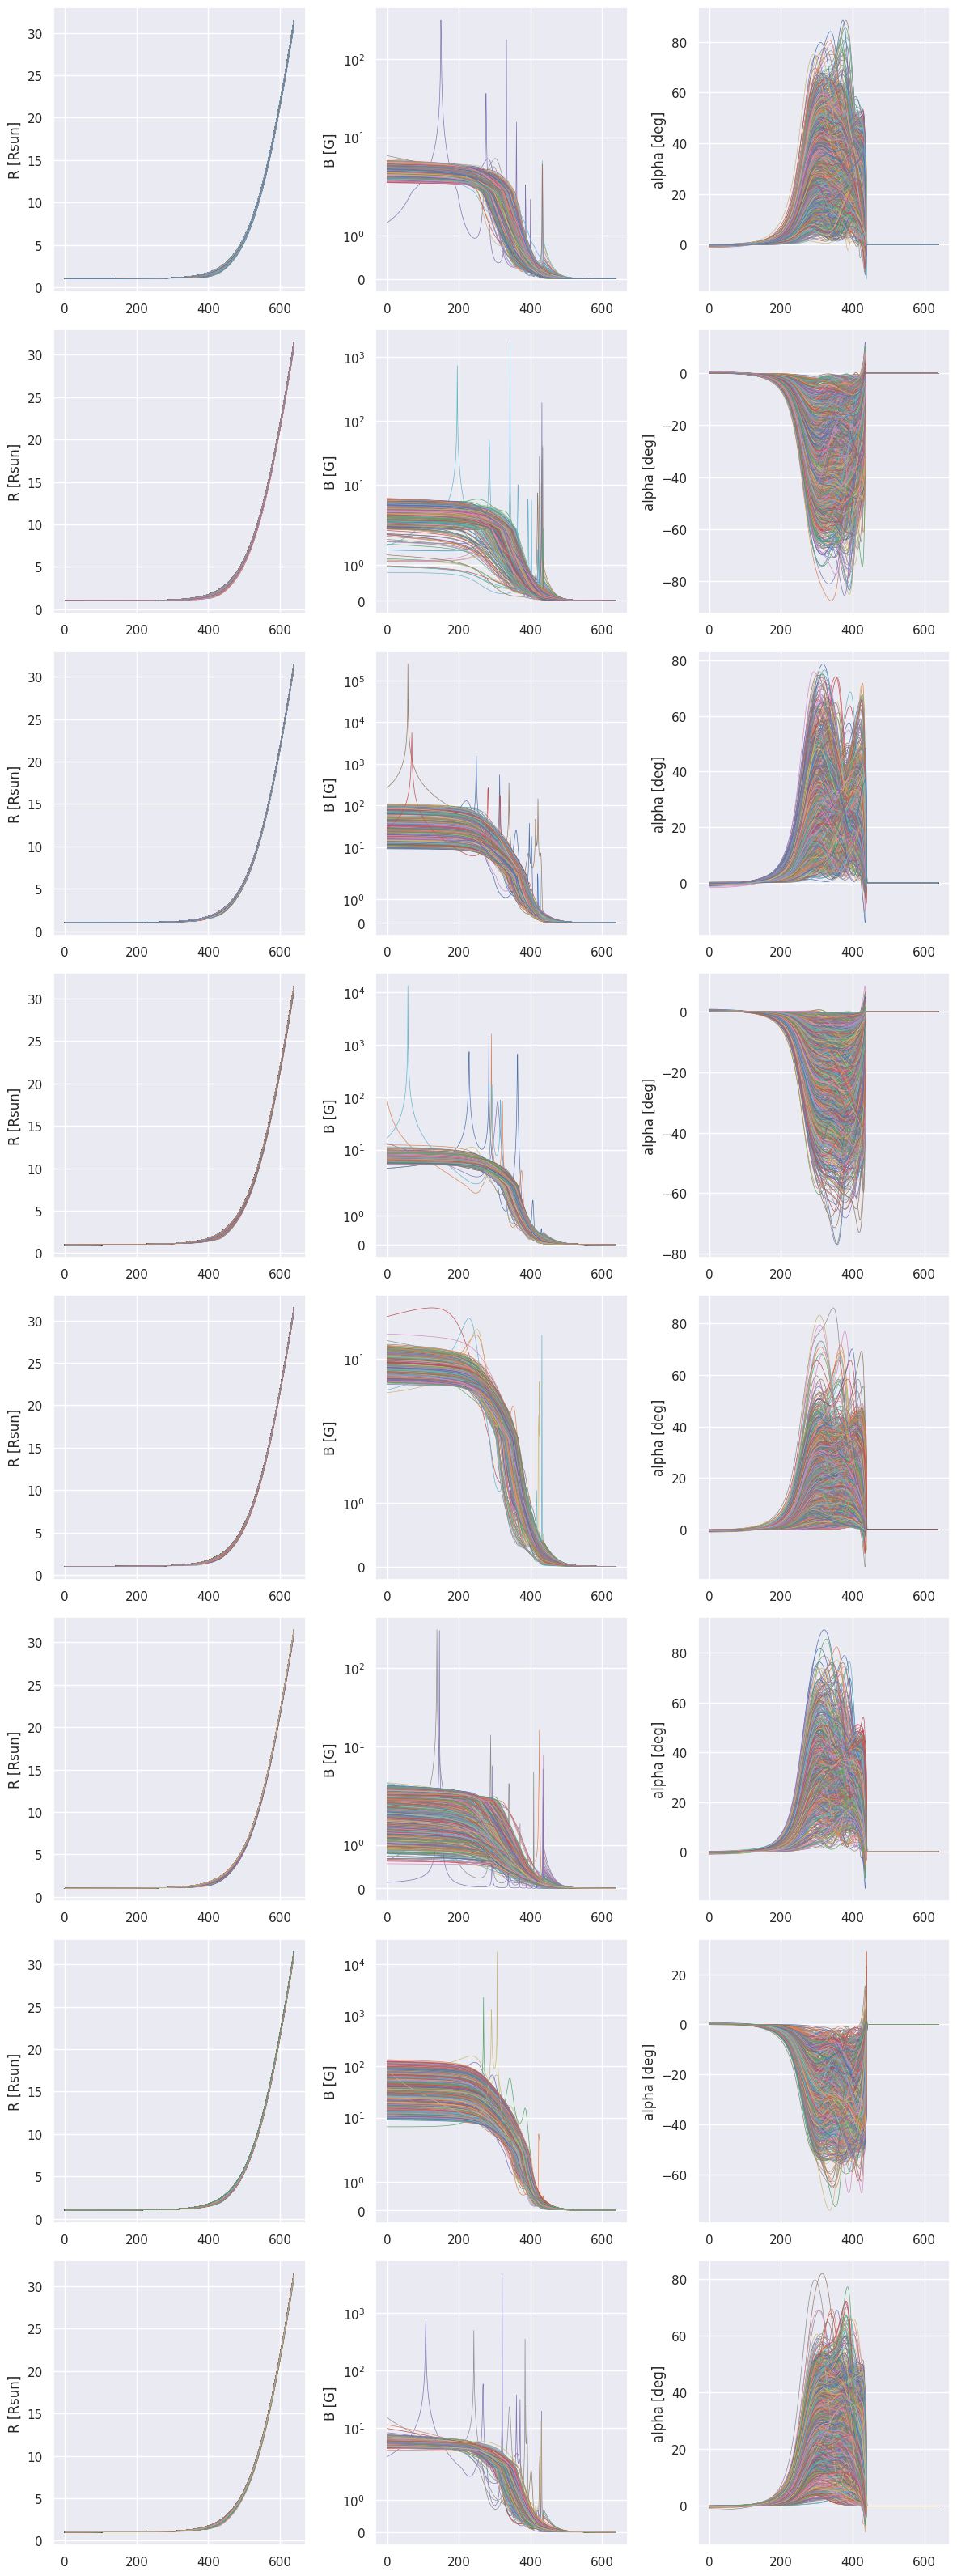

In [36]:
plot_unscaled_clusters(pca_kmeans_mag_inc_labels, nclusters, flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'Number of files')]

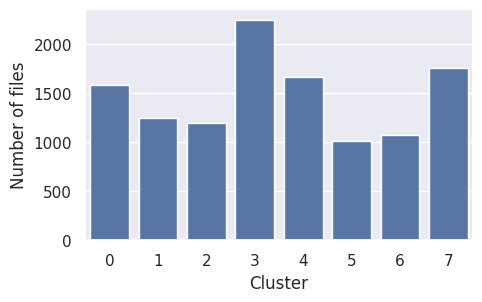

In [37]:
fig, ax = plt.subplots(figsize=(5, 3))
bp = sns.countplot(x=pca_kmeans_mag_inc_labels, ax=ax, color='b')
bp.set(xlabel='Cluster', ylabel='Number of files')

## Hierarchical Clustering

In [38]:
agg = AgglomerativeClustering(compute_distances=True, n_clusters=4, compute_full_tree=True, linkage='average')
agg = agg.fit(transformed_mag_inc)
nclusters = len(set(agg.labels_))

Text(0.5, 0, 'Number of points in node')

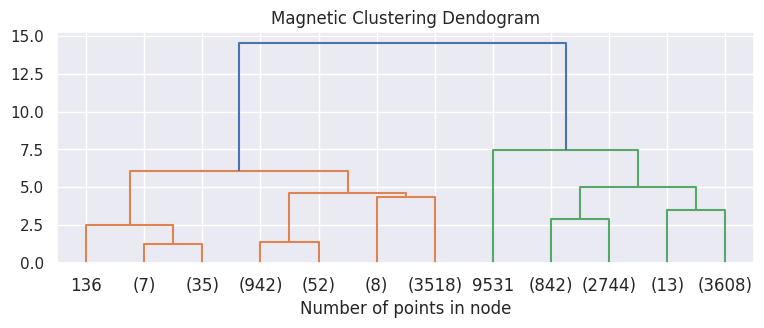

In [39]:
plt.figure(figsize=(9, 3))
plt.title("Magnetic Clustering Dendogram")
plot_dendrogram(agg, truncate_mode='level', p=3)
plt.xlabel("Number of points in node")

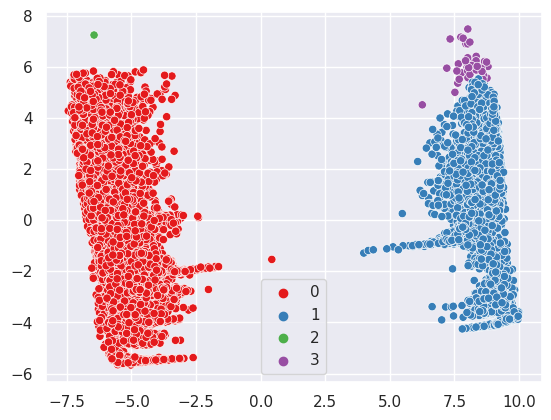

In [40]:
sp = sns.scatterplot(x=transformed_mag_inc[:, 0], y=transformed_mag_inc[:, 1], hue=agg.labels_, palette='Set1')
# sp.legend_.remove()


### Original Data

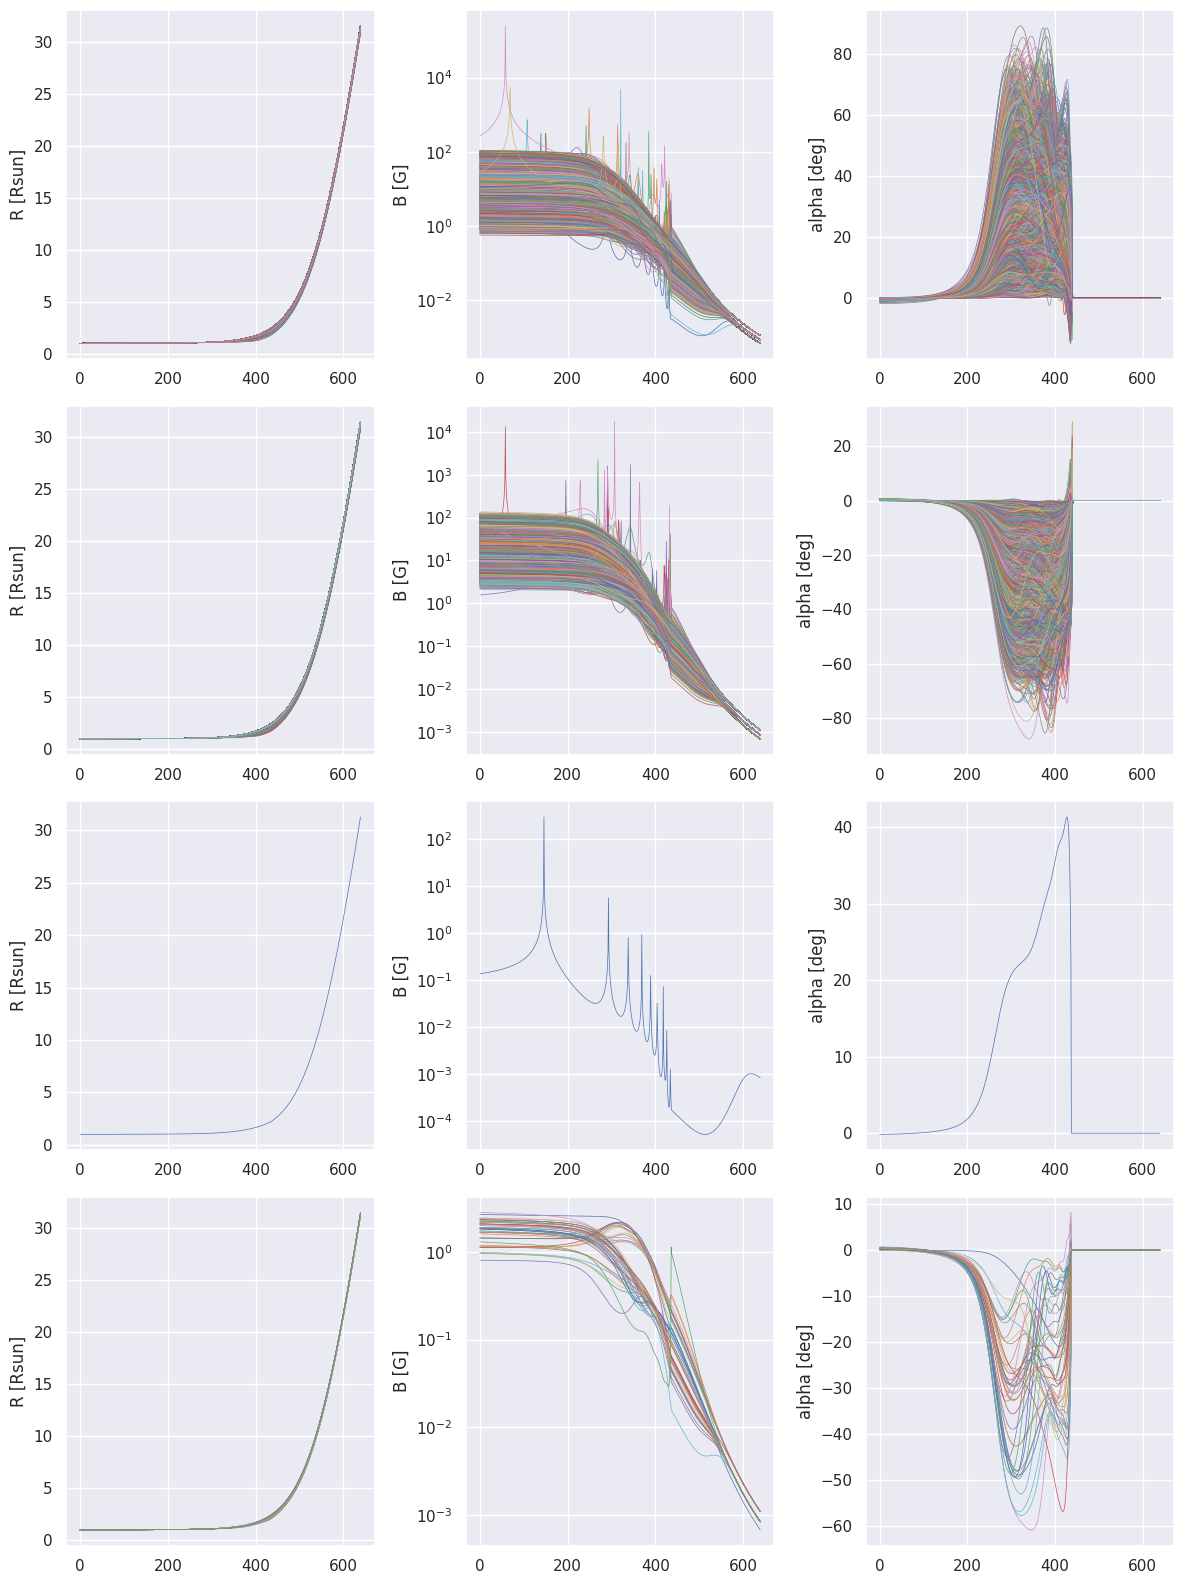

In [41]:
plot_unscaled_clusters(agg.labels_, nclusters, flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

<AxesSubplot: ylabel='count'>

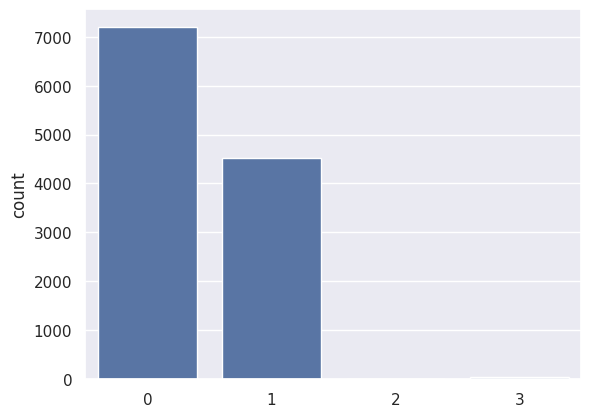

In [42]:
sns.countplot(x=agg.labels_, color='b')

In [43]:
# %%capture
# sub_dir = OUT_DIR / 'alpha'
# if not sub_dir.exists():
#     sub_dir.mkdir()
    
# for i in range(2, MAX_CLUSTERS):
#     agg = AgglomerativeClustering(compute_distances=True, n_clusters=i, compute_full_tree=True, linkage='average')
#     agg = agg.fit(transformed_alpha)
    
#     sp = sns.scatterplot(x=transformed_alpha[:, 0], y=transformed_alpha[:, 1], hue=agg.labels_, palette='Set1')
    
        
#     plt.savefig(sub_dir / f'hierarch_scatter_{len(set(agg.labels_))}.png', dpi=200)
    
#     plot_unscaled_clusters(agg.labels_, len(set(agg.labels_)), flows_dict, flow_columns, 
#                            save_path=sub_dir / f'hierarch_{len(set(agg.labels_))}.png', yscale={'B [G]': 'log'}) 
    

## DBSCAN

In [44]:
dbscan = DBSCAN(eps=0.25, min_samples=10, n_jobs=2)
dbscan_mag_inc_labels = dbscan.fit_predict(transformed_mag_inc)
nclusters = len(set(dbscan_mag_inc_labels))


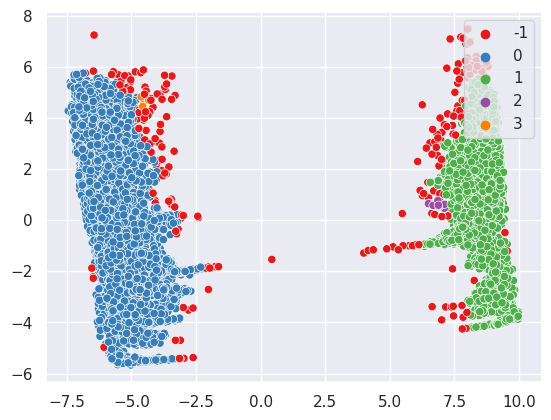

In [45]:
sp = sns.scatterplot(x=transformed_mag_inc[:, 0], y=transformed_mag_inc[:, 1], hue=dbscan_mag_inc_labels, palette='Set1')
plt.legend(loc='upper right')

### Original Data

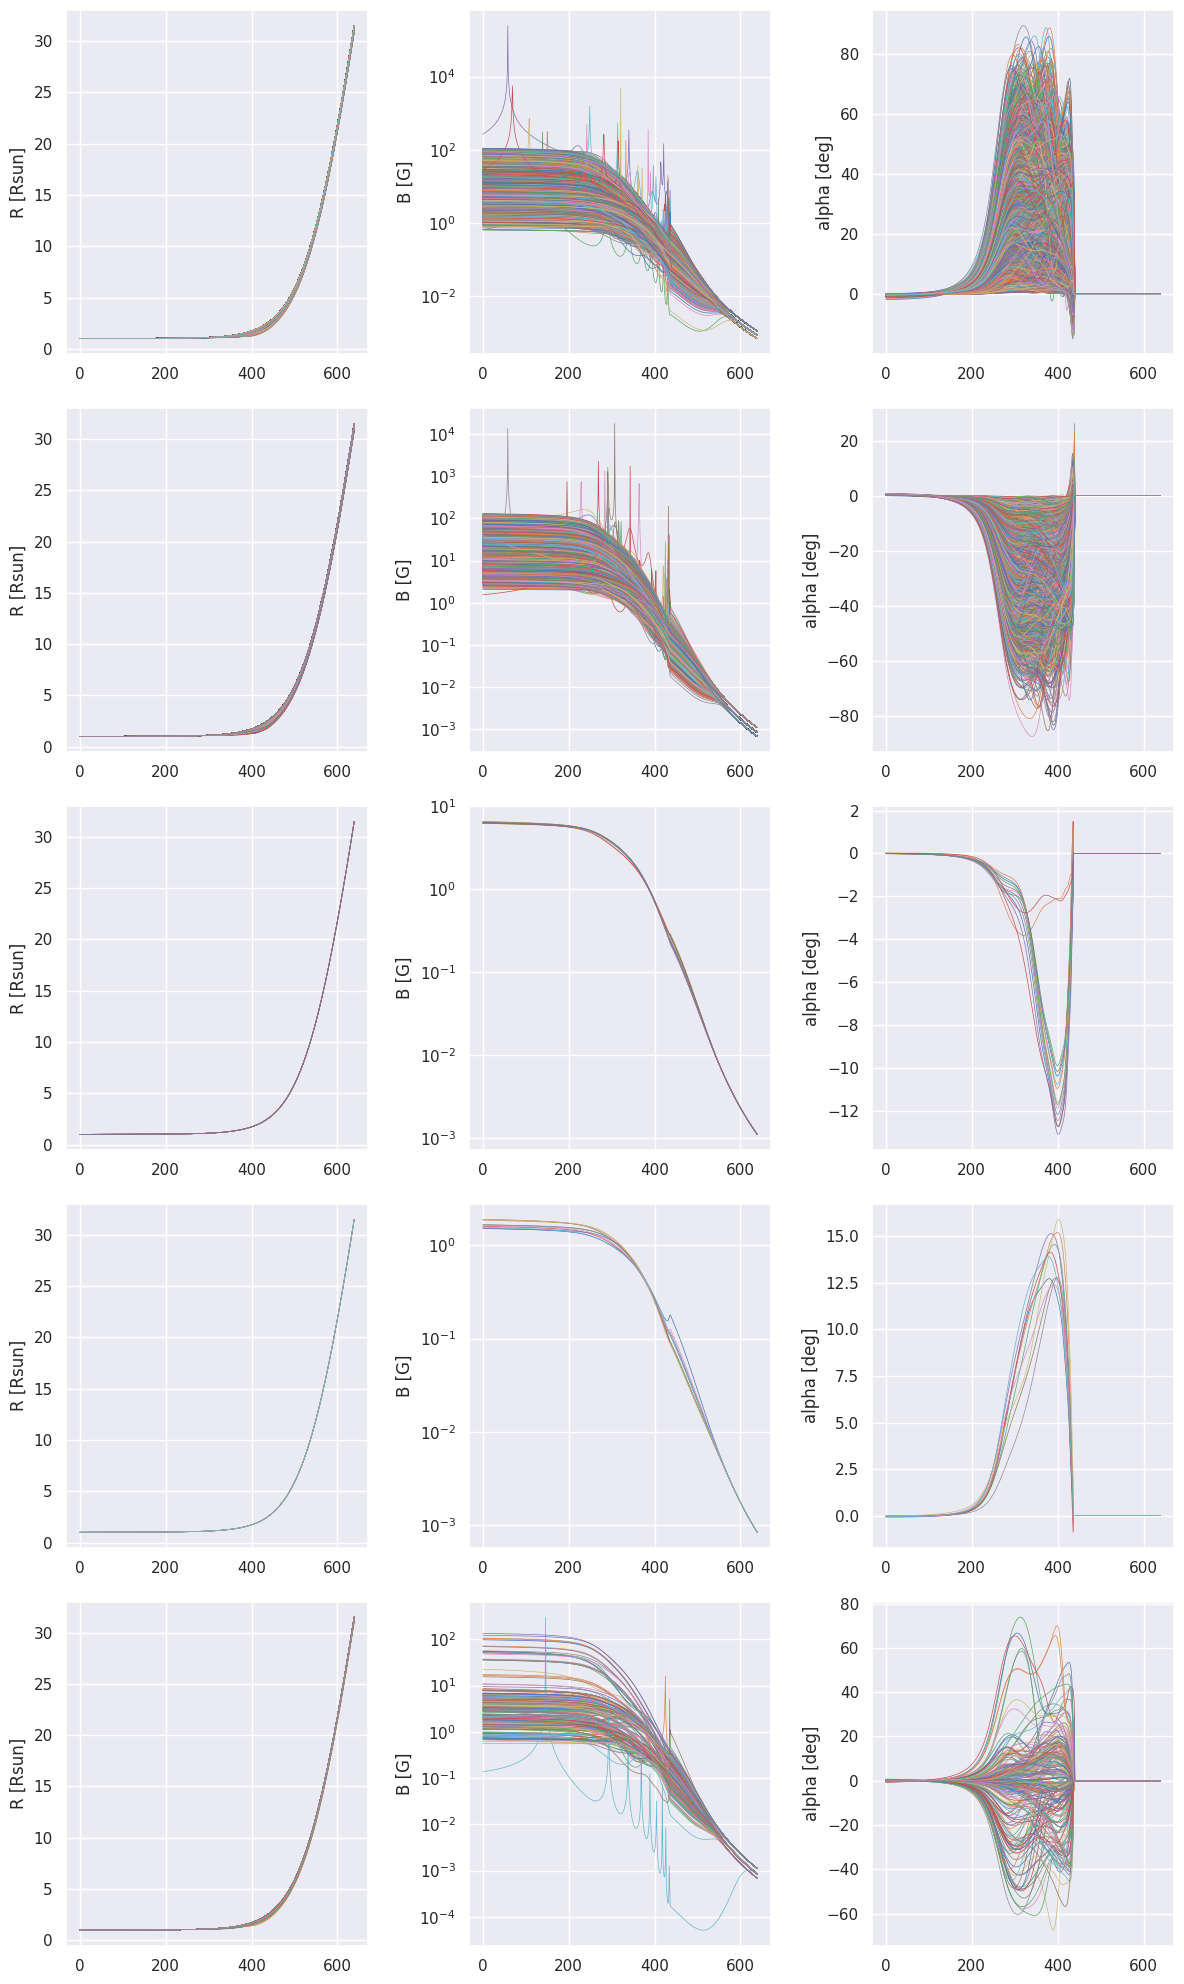

In [46]:
plot_unscaled_clusters(dbscan_mag_inc_labels, nclusters, flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

<AxesSubplot: ylabel='count'>

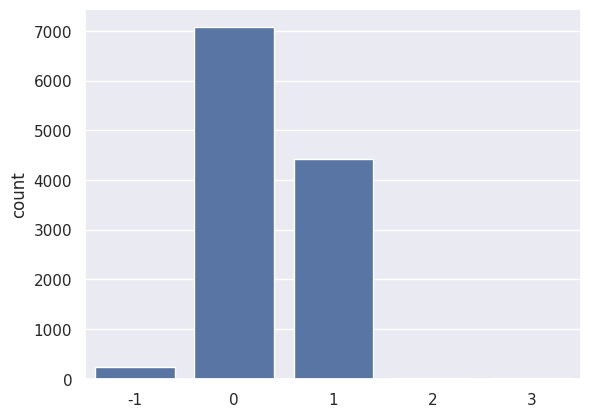

In [47]:
sns.countplot(x=dbscan_mag_inc_labels, color='b')

In [48]:
# %%capture
# sub_dir = OUT_DIR / 'alpha_dbscan'
# if not sub_dir.exists():
#     sub_dir.mkdir()
# for i in np.arange(0.2, 0.5, 0.05):
#     dbscan = DBSCAN(eps=i, min_samples=10, n_jobs=2)
#     dbscan_alpha_labels = dbscan.fit_predict(transformed_alpha)
    
#     save_i = int(round(i, 2) *100)
#     sp = sns.scatterplot(x=transformed_alpha[:, 0], y=transformed_alpha[:, 1], hue=dbscan_alpha_labels, palette='Set1')
#     plt.legend(loc='upper right')
#     plt.savefig(sub_dir / f'dbscan_scatter_{save_i}.png', dpi=200)
    
#     plot_unscaled_clusters(dbscan_alpha_labels, len(set(dbscan_alpha_labels)), flows_dict, flow_columns, save_path=sub_dir / f'dbscan_{save_i}.png')
    